# 07. Function Inference

Author: Minghang Li

In this Jupyter Notebook, we perform function inference using the `picrust2`
plugin based on amplicon-based sequencing results.

<div style="background-color: lightsalmon; padding: 10px;">
    
**NOTE**: `q2-picrust2` plugin is not directly compatible with `qiime2-2024.10` as of now. We need to manually install the plugin from source and modify `setup.py` to make it compatible with the current version of `qiime2`.
</div>



**Notebook overview**<br>
[1. Setup](#1-setup)<br>
[2. Run `picrust2` full pipeline](#2-run-picrust2-full-pipeline)<br>
[3. Analysis and Visualization](#3-visualization)<br>
[4. Thoughts and discussion](#4-thoughts-and-discussion)<br>

## 1. Setup

In [1]:
# importing all required packages & notebook extensions at the start of the notebook
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
from pathlib import Path

%matplotlib inline

In [2]:
# get project root by finding .git folder
root = !git rev-parse --show-toplevel
root = root[0]

# assigning variables throughout the notebook
raw_data_dir = os.path.join(root, "data/raw")
data_dir = os.path.join(root, "data/processed")
vis_dir  = os.path.join(root, "results")

## 2. Run `picrust2` full pipeline

PICRUSt2 (Phylogenetic Investigation of Communities by Reconstruction of Unobserved States) is a software for predicting functional abundances based only on marker gene (here, it's 16S rRNA) sequences.

"Function" here refers to gene families such as KEGG orthologs (KO), Enzyme Classification (EC) numbers, and metabolic (MetaCyc) pathways.

Here we use **maximum parsimony** (`mp`) for hidden state predcition (HSP) and **SEPP** (SATé-Enabled Phylogenetic Placement) method for tree placement (cannot use `EPA-NG` due to limited RAM + trying to be consistent with `q2-feature-insertion`). `--p-edge-exponent` was set to be `0` for the pipeline to run successfully (as SEPP handles branch weighing internally)

<div style="background-color: aliceblue; padding: 10px;">

**NOTE** `qiime picrust2 custom-tree-pipeline` can only use trees built from `aiime fragment-insertion sepp` as an input. So the tree built in `03_phylogeny.ipynb` cannot be used.
</div>

In [ ]:
! qiime picrust2 full-pipeline \
    --i-table $data_dir/table-filtered.qza \
    --i-seq $data_dir/rep-seqs-filtered.qza \
    --p-threads 16 \
    --p-hsp-method mp \
    --p-edge-exponent 0 \
    --p-placement-tool sepp \
    --output-dir $data_dir/q2-picrust2_fullpipeline \
    --verbose

## 3. Downstream Analysis and Visualization


In [3]:
picrust_res = f"{data_dir}/q2-picrust2_fullpipeline"

### 3.1 Summarize the table

Summarize the information using `feature-table summarize`

In [4]:
! qiime feature-table summarize \
   --i-table $picrust_res/ko_metagenome.qza \
   --o-visualization $picrust_res/ko_metagenome.qzv

! qiime feature-table summarize \
   --i-table $picrust_res/ec_metagenome.qza \
   --o-visualization $picrust_res/ec_metagenome.qzv

! qiime feature-table summarize \
   --i-table $picrust_res/pathway_abundance.qza \
   --o-visualization $picrust_res/pathway_abundance.qzv

QIIME is caching your current deployment for improved performance. This may take a few moments and should only happen once per deployment.
Saved Visualization to: /home/matchy233/study/alien/data/processed/q2-picrust2_fullpipeline/ko_metagenome.qzv
Saved Visualization to: /home/matchy233/study/alien/data/processed/q2-picrust2_fullpipeline/ec_metagenome.qzv
Saved Visualization to: /home/matchy233/study/alien/data/processed/q2-picrust2_fullpipeline/pathway_abundance.qzv


In [5]:
Visualization.load(f"{picrust_res}/ko_metagenome.qzv")

<visualization: Visualization uuid: 9cd5edf0-56a5-43aa-94c9-2b3c028fe41c>

In [29]:
Visualization.load(f"{picrust_res}/ec_metagenome.qzv")

<visualization: Visualization uuid: d5c7f04f-a737-4c53-948b-653d760ee61c>

In [30]:
Visualization.load(f"{picrust_res}/pathway_abundance.qzv")

<visualization: Visualization uuid: 5a8f31d6-c765-4501-8ec5-f786e609da69>

### 3.2 Compute diversity

#### 3.2.1 KEGG

In [12]:
! qiime diversity alpha-rarefaction \
    --i-table $picrust_res/ko_metagenome.qza \
    --p-max-depth 30000 \
    --m-metadata-file $data_dir/metadata.tsv \
    --o-visualization $data_dir/ko_metagenome/alpha-rarefaction-ko.qzv

^C

Aborted!


In [16]:
! qiime diversity core-metrics \
   --i-table $picrust_res/ko_metagenome.qza \
   --p-sampling-depth 10000 \
   --m-metadata-file $data_dir/metadata.tsv \
   --output-dir $data_dir/ko_metagenome_core_metrics \
   --parallel \
   --p-n-jobs 16

Saved FeatureTable[Frequency] to: /home/matchy233/study/alien/data/processed/ko_metagenome_core_metrics/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: /home/matchy233/study/alien/data/processed/ko_metagenome_core_metrics/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: /home/matchy233/study/alien/data/processed/ko_metagenome_core_metrics/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: /home/matchy233/study/alien/data/processed/ko_metagenome_core_metrics/evenness_vector.qza
Saved DistanceMatrix to: /home/matchy233/study/alien/data/processed/ko_metagenome_core_metrics/jaccard_distance_matrix.qza
Saved DistanceMatrix to: /home/matchy233/study/alien/data/processed/ko_metagenome_core_metrics/bray_curtis_distance_matrix.qza
Saved PCoAResults to: /home/matchy233/study/alien/data/processed/ko_metagenome_core_metrics/jaccard_pcoa_results.qza
Saved PCoAResults to: /home/matchy233/study/alien/data/processed/ko_metagenome_core_metrics/bray_curtis_pcoa_results.qza


#### 3.2.2 EC counts

In [ ]:
! qiime diversity alpha-rarefaction \
    --i-table $picrust_res/ec_metagenome.qza \
    --p-max-depth 10000 \
    --m-metadata-file $data_dir/metadata.tsv \
    --o-visualization $data_dir/alpha-rarefaction-ec.qzv

In [17]:
! qiime diversity core-metrics \
   --i-table $picrust_res/ec_metagenome.qza \
   --p-sampling-depth 10000 \
   --m-metadata-file $data_dir/metadata.tsv \
   --output-dir $data_dir/ec_metagenome_core_metrics \
   --parallel \
   --p-n-jobs 16

Saved FeatureTable[Frequency] to: ec_metagenome_core_metrics/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: ec_metagenome_core_metrics/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: ec_metagenome_core_metrics/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: ec_metagenome_core_metrics/evenness_vector.qza
Saved DistanceMatrix to: ec_metagenome_core_metrics/jaccard_distance_matrix.qza
Saved DistanceMatrix to: ec_metagenome_core_metrics/bray_curtis_distance_matrix.qza
Saved PCoAResults to: ec_metagenome_core_metrics/jaccard_pcoa_results.qza
Saved PCoAResults to: ec_metagenome_core_metrics/bray_curtis_pcoa_results.qza
Saved Visualization to: ec_metagenome_core_metrics/jaccard_emperor.qzv
Saved Visualization to: ec_metagenome_core_metrics/bray_curtis_emperor.qzv


#### 3.2.3 Path abundance

In [ ]:
! qiime diversity alpha-rarefaction \
    --i-table $picrust_res/pathway_abundance.qza \
    --p-max-depth 5000 \
    --m-metadata-file $data_dir/metadata.tsv \
    --o-visualization $data_dir/alpha-rarefaction-pathabund.qzv

In [18]:
! qiime diversity core-metrics \
   --i-table $picrust_res/pathway_abundance.qza \
   --p-sampling-depth 5000 \
   --m-metadata-file $data_dir/metadata.tsv \
   --output-dir $data_dir/pathway_abundance_core_metrics \
   --parallel \
   --p-n-jobs 16

Saved FeatureTable[Frequency] to: pathway_abundance_core_metrics/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: pathway_abundance_core_metrics/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: pathway_abundance_core_metrics/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: pathway_abundance_core_metrics/evenness_vector.qza
Saved DistanceMatrix to: pathway_abundance_core_metrics/jaccard_distance_matrix.qza
Saved DistanceMatrix to: pathway_abundance_core_metrics/bray_curtis_distance_matrix.qza
Saved PCoAResults to: pathway_abundance_core_metrics/jaccard_pcoa_results.qza
Saved PCoAResults to: pathway_abundance_core_metrics/bray_curtis_pcoa_results.qza
Saved Visualization to: pathway_abundance_core_metrics/jaccard_emperor.qzv
Saved Visualization to: pathway_abundance_core_metrics/bray_curtis_emperor.qzv


In [6]:
pathabun = q2.Artifact.load(f"{picrust_res}/pathway_abundance.qza").view(pd.DataFrame)
pathabun.head()

,1CMET2-PWY,3-HYDROXYPHENYLACETATE-DEGRADATION-PWY,AEROBACTINSYN-PWY,ALL-CHORISMATE-PWY,ANAEROFRUCAT-PWY,ANAGLYCOLYSIS-PWY,ARG+POLYAMINE-SYN,ARGDEG-PWY,ARGORNPROST-PWY,ARGSYN-PWY,...,THISYN-PWY,THREOCAT-PWY,THRESYN-PWY,TRNA-CHARGING-PWY,TRPSYN-PWY,TYRFUMCAT-PWY,UBISYN-PWY,UDPNAGSYN-PWY,VALDEG-PWY,VALSYN-PWY
EG0024,116613.984453,73.424692,63.643626,1026.966436,27815.373858,151411.464318,2608.113398,252.180004,4558.641993,107229.507915,...,94380.275853,259.752512,110387.739891,110445.977771,105577.623217,0.000000,339.050562,34476.365984,0.0,162192.010400
EG0031,136253.349598,63725.681123,64514.001632,148867.177540,167925.553339,169866.365287,144954.170796,141759.514298,87195.474330,161750.564324,...,120603.131866,204.378689,163193.943180,142500.286816,156707.938691,26.996907,145507.073631,130545.837853,0.0,163119.763567
EG0039,77411.718837,0.000000,39.073526,5988.831451,84702.114029,103051.671420,14120.130585,4853.163308,5341.081270,33180.001699,...,16654.384958,5807.628900,43766.580400,77373.310502,33170.646036,14.660025,3782.890741,78984.024230,0.0,55215.280267
EG0055,181117.459408,43.401534,49.754902,433.312325,233345.335016,214956.294156,432.364351,143.700771,5556.457529,14290.748880,...,340.750434,192.351322,218178.886473,8956.587539,22821.853759,2.059130,143.420182,182571.575573,0.0,12403.531249
EG0057,53230.419360,32.435472,25.315068,133.563270,83460.634850,90371.770969,119.174362,41.711924,50651.344895,20611.037128,...,458.877527,72.135985,57783.902711,3151.556643,22091.600950,29.857820,40.349876,78450.424058,0.0,31334.792862


### 3.3 Visualize the results

We chose to visualize the **MetaCyc** pathway abundances for the following reasons:

1. The identifiers are more informative than KEGG orthologs (contains pathway name like `BIOTIN-BIOSYNTHESIS-PWY`)
2. MetaCyc is a review-based database, which means the pathways are manually curated and more reliable than KEGG orthologs.
3. KEGG currently goes closed-source. The author of this notebook personally prefers open-source databases.

Text(0.5, 1.0, 'Pathway abundance')

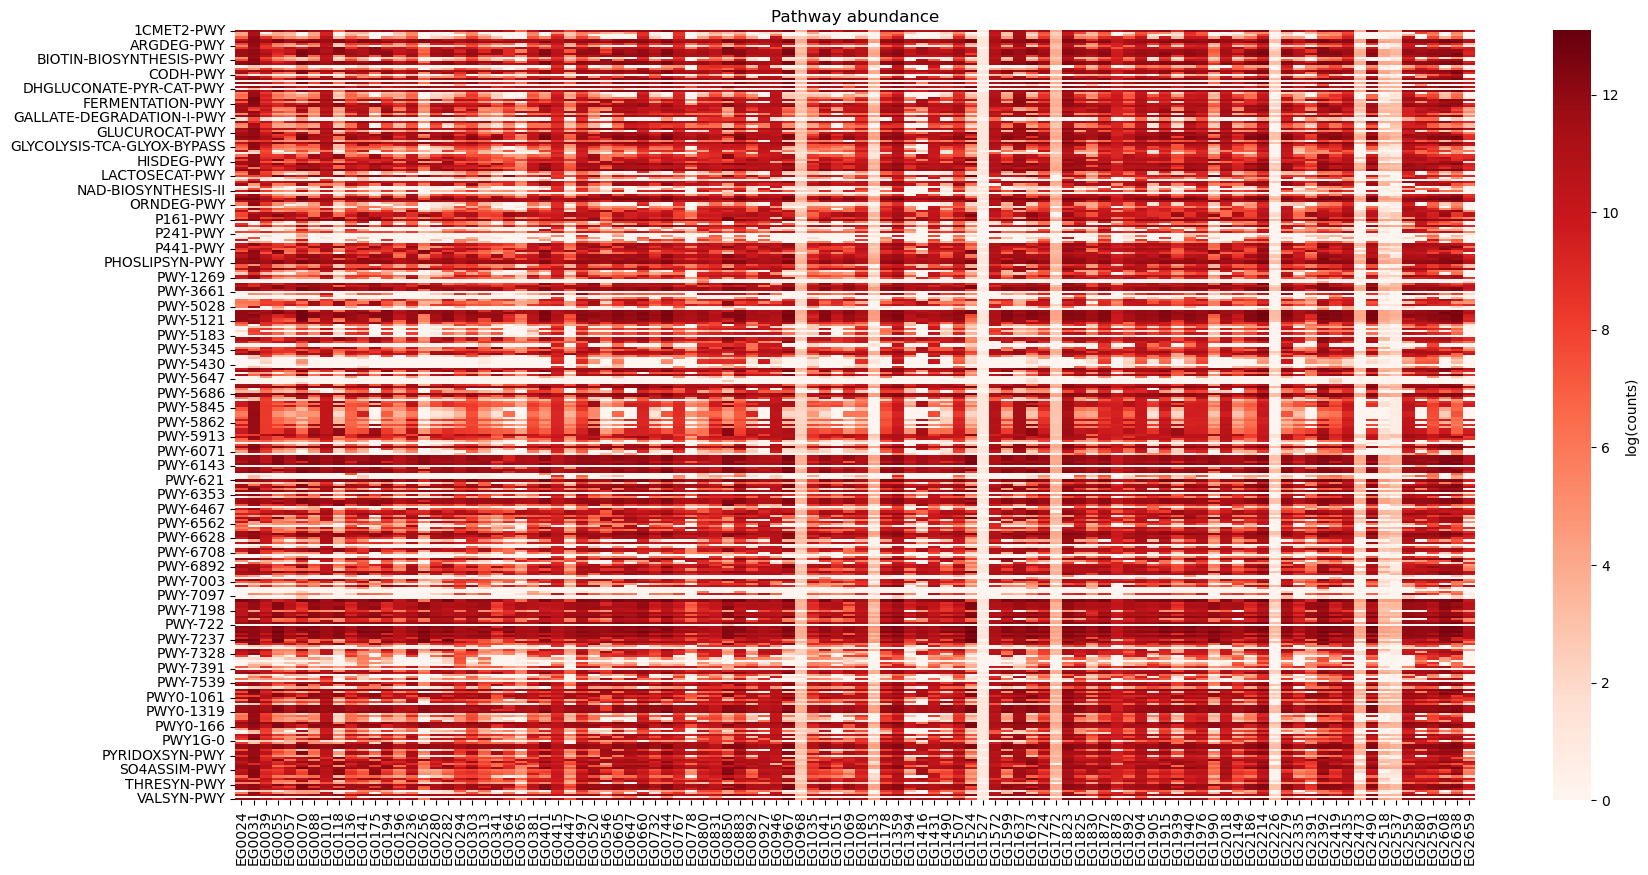

In [ ]:
# visualize the data using a heatmap
pathabun = pathabun.astype(float)
pathabun_log = np.log(pathabun + 1)

plt.figure(figsize=(20, 10))
sns.heatmap(pathabun_log.T, cmap="Reds", cbar_kws={'label': 'log(counts)'}, xticklabels=pathabun_log.index)
plt.title("Pathway abundance")
plt.savefig(f"{vis_dir}/pathway_abundance_heatmap.png")

Hey, we see some samples with similar functional profiles. Let's try cluster map to see if we can find some patterns.

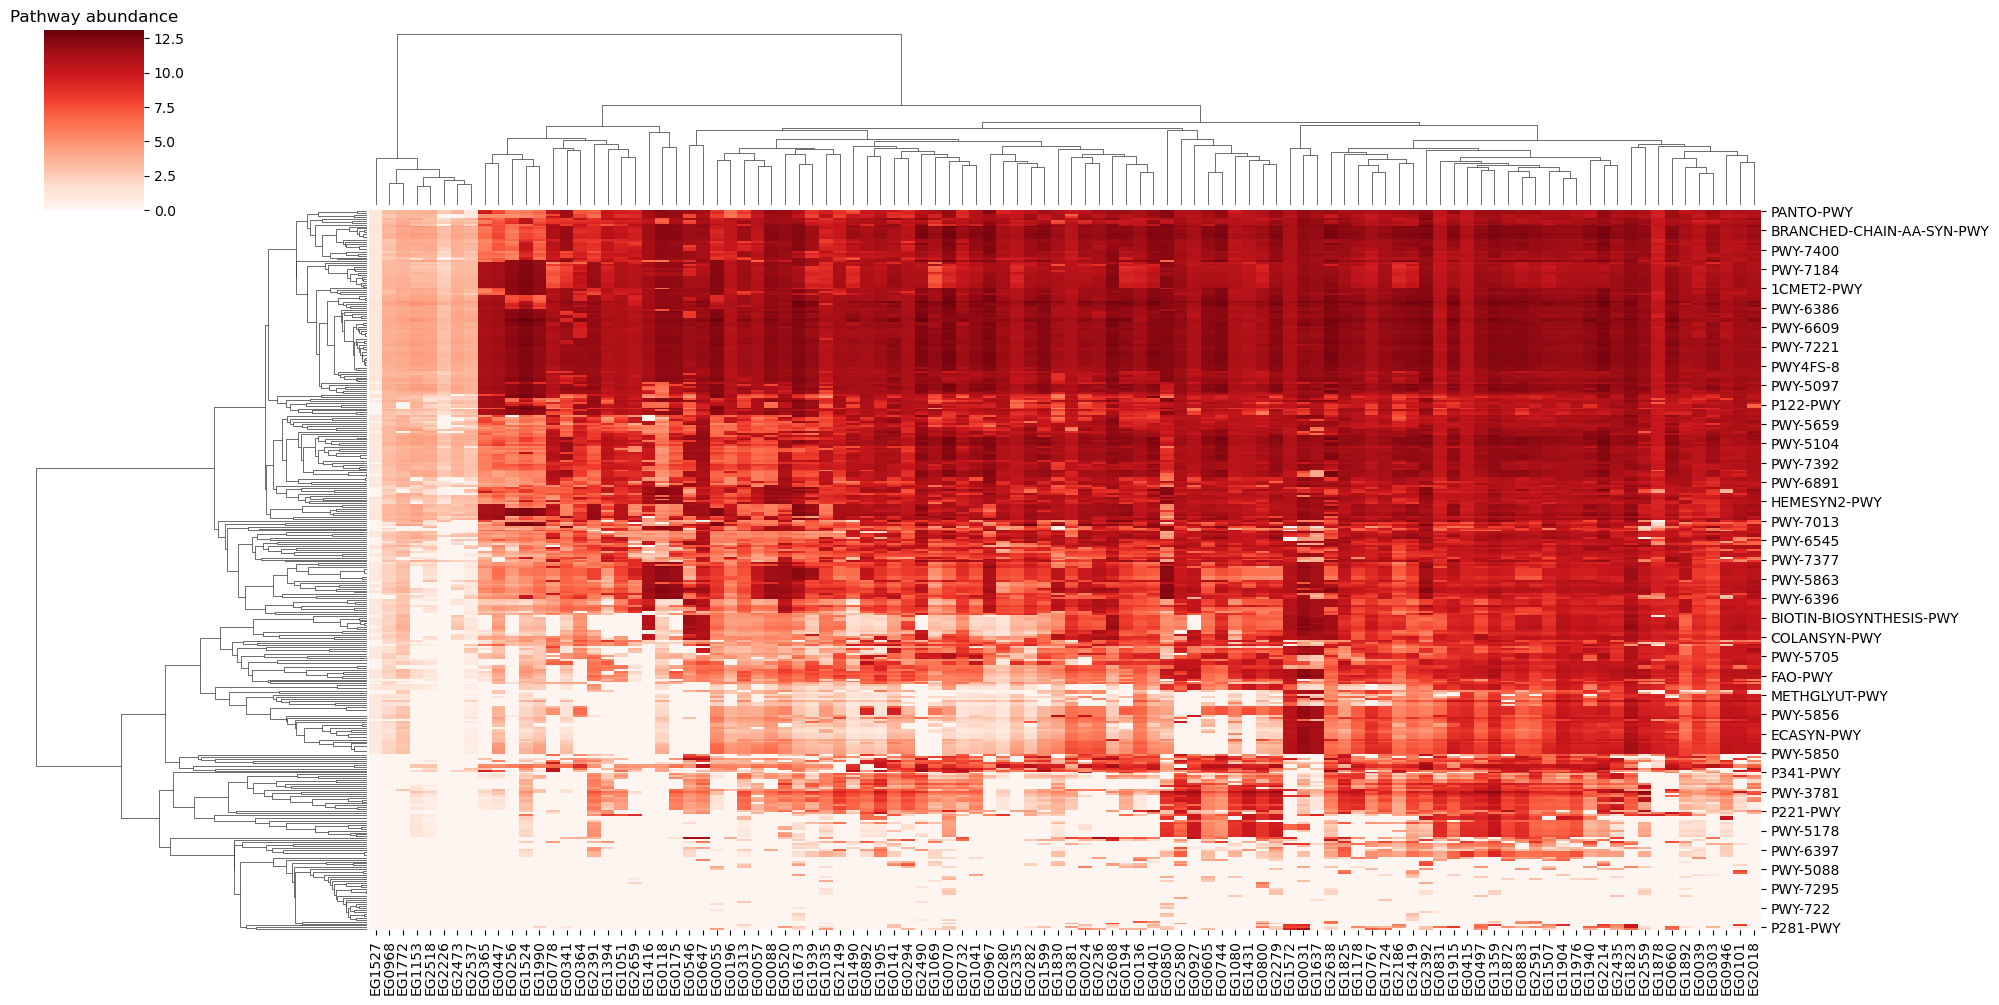

In [13]:
# visualize the data using a clustermap
sns.clustermap(pathabun_log.T, cmap="Reds", xticklabels=pathabun_log.index, figsize=(20, 10))
plt.title("Pathway abundance")
plt.savefig(f"{vis_dir}/pathway_abundance_clustermap.png")

Now that we can confirm there are indeed some function patterns in the data. We can try to do some statistical tests to see if the patterns are significant. For example. between cohorts.

### 3.4 Differential Abundance between Cohorts

In [ ]:
!

## 4. Thoughts and Discussion

Although amplicon-based predictions may be highly correlated with functional profiles based on shotgun metagenomics sequencing data, differential abundance results will likely differ substantially from what would be found based on shotgun metagenomics data. As we requested data from our TA, it is important to compare the results generated from shotgun metagenomics analysis with the prediction from picrust.

## Bibliography

[1] G. M. Douglas et al., “PICRUSt2 for prediction of metagenome functions,” Nature Biotechnology, vol. 38, no. 6, pp. 685–688, Jun. 2020, doi: https://doi.org/10.1038/s41587-020-0548-6.

‌[2] S. Purushothaman, M. Meola, and A. Egli, “Combination of Whole Genome Sequencing and Metagenomics for Microbiological Diagnostics,” International Journal of Molecular Sciences, vol. 23, no. 17, p. 9834, Aug. 2022, doi: https://doi.org/10.3390/ijms23179834.
‌